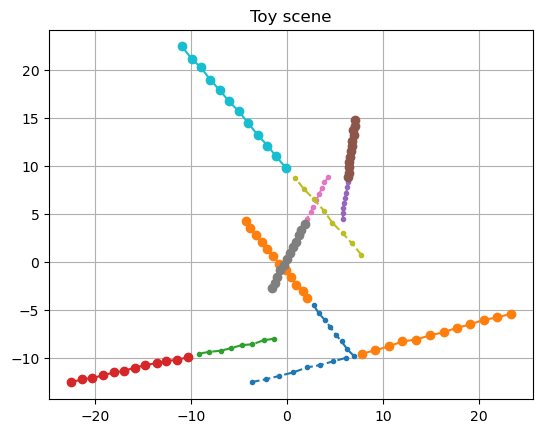

In [1]:
from utils.preprocessing import make_toy_batch
from visualize.plot import plot_scene

batch = make_toy_batch(num_scenes=1, agents_per_scene=6)
plot_scene(batch["past"][0], batch["future"][0])


In [4]:
from models.baselines import predict_cv
from evaluation.metrics import rmse, count_collisions

past, future = batch["past"][0], batch["future"][0]
pred = predict_cv(past, future.shape[1])

print("RMSE:", rmse(pred, future))
print("Collisions (pred):", count_collisions(pred))
print("Collisions (gt):", count_collisions(future))


RMSE: 0.5080116775112928
Collisions (pred): 1
Collisions (gt): 0
